In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

# Precipitation Analysis

In [17]:
# Latest Date in DataFrame
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [26]:
# Calculate the Date 1 Year Ago from the Last Data Point in the Database
one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
one_year_ago

datetime.date(2016, 8, 23)

In [50]:
# Design a Query to Retrieve the Last 12 Months of Precipitation Data and plot the results
prcp_data= session.query(Measurement.date, Measurement.prcp) \
                      .filter(Measurement.date >= dt.datetime.strftime(one_year_ago, "%Y-%m-%d")) \
                      .filter(Measurement.prcp.isnot(None)) \
                      .order_by(Measurement.date).all()

In [51]:
# Perform a Query to Retrieve the Data and Precipitation Scores
all_scores = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc()).all()

In [52]:
# Save the Query Results as a Pandas DataFrame and Set the Index to the Date Column & Sort the Dataframe Values by `date`
prcp_df = pd.DataFrame(prcp_data, columns=["Date","Precipitation"])
prcp_df.set_index("Date", inplace=True,)
prcp_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


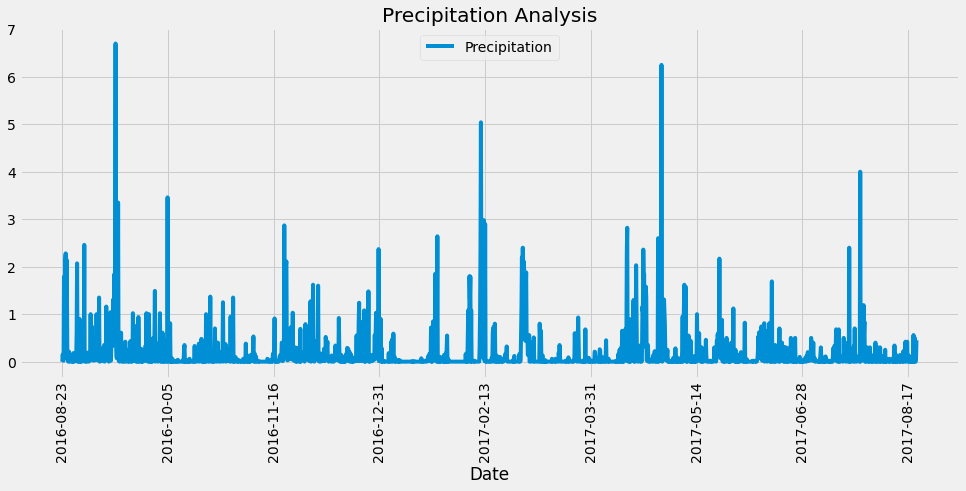

In [53]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(title="Precipitation Analysis", figsize=(15,6))
plt.legend(loc='upper center')
plt.xticks(rotation=90)
plt.savefig("Images/precipitation.png")
plt.show()

In [54]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [56]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station).group_by(Station.station).count()
stations

9

In [94]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_active = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
stations_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [95]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
max = session.query(func.max(Measurement.tobs)).all()
min = session.query(func.min(Measurement.tobs)).all()
avg = session.query(func.avg(Measurement.tobs)).all()

print(min, max, avg)

[(53.0,)] [(87.0,)] [(73.09795396419437,)]


In [88]:
most_active = session.query(Measurement.station, Station.name, func.count(Station.id)) \
                  .filter(Measurement.station == Station.station) \
                  .group_by(Station.station, Station.name) \
                  .order_by(func.count(Station.id).desc()).first()
most_active

('USC00519281', 'WAIHEE 837.5, HI US', 2772)

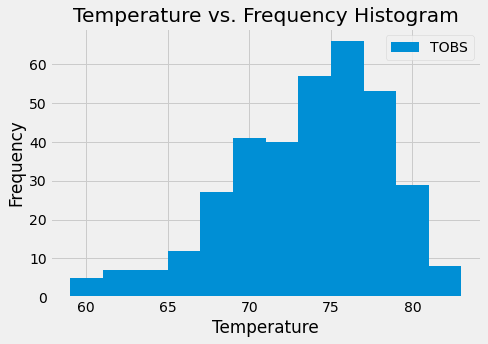

In [102]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(Measurement.tobs).\
    filter(Measurement.date >= one_year_ago).\
    filter(Measurement.station == "USC00519281").\
    order_by(Measurement.date).all()

# Save the Query Results as a Pandas DataFrame
tobs_data_df = pd.DataFrame(tobs_data, columns=["TOBS"])

# We need 12 bins since the observation is for twelve months

tobs_data_df.plot.hist(bins=12, title="Temperature vs. Frequency Histogram", figsize=(7,5))
plt.xlabel("Temperature")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig("Images/StationAnalysis.png")
plt.show()

## Bonus Challenge Assignment

# Temperature Analysis I

In [116]:
#Average temperature in June at all stations across all available years in the dataset.
avg_temp_j= session.query(func.strftime("%Y-%m", Measurement.date), func.avg(Measurement.tobs)) \
                    .filter(func.strftime("%m",Measurement.date) == '06') \
                    .group_by(func.strftime("%Y",Measurement.date)) \
                    .all()
avg_temp_j

[('2010-06', 74.92561983471074),
 ('2011-06', 73.93832599118943),
 ('2012-06', 74.0),
 ('2013-06', 74.59907834101382),
 ('2014-06', 75.02790697674419),
 ('2015-06', 74.99014778325123),
 ('2016-06', 75.17525773195877),
 ('2017-06', 77.21989528795811)]

In [117]:
#Average temperature in december at all stations across all available years in the dataset.
avg_temps_d = session.query(func.strftime("%Y-%m", Measurement.date), func.avg(Measurement.tobs)) \
                    .filter(func.strftime("%m",Measurement.date) == '12') \
                    .group_by(func.strftime("%Y",Measurement.date)) \
                    .all()
avg_temps_d

[('2010-12', 70.20851063829787),
 ('2011-12', 70.82062780269058),
 ('2012-12', 71.18807339449542),
 ('2013-12', 71.09401709401709),
 ('2014-12', 69.89686098654708),
 ('2015-12', 73.42391304347827),
 ('2016-12', 71.13)]

In [118]:
#June TOBS for All Years in The Data Set
june_temp=(session.query(Measurement.date,Measurement.tobs)
               .filter(func.strftime('%m',Measurement.date) == '06')
               .all())
june_temp

[('2010-06-01', 78.0),
 ('2010-06-02', 76.0),
 ('2010-06-03', 78.0),
 ('2010-06-04', 76.0),
 ('2010-06-05', 77.0),
 ('2010-06-06', 78.0),
 ('2010-06-07', 77.0),
 ('2010-06-08', 78.0),
 ('2010-06-09', 78.0),
 ('2010-06-10', 79.0),
 ('2010-06-11', 78.0),
 ('2010-06-12', 78.0),
 ('2010-06-13', 78.0),
 ('2010-06-14', 77.0),
 ('2010-06-15', 78.0),
 ('2010-06-16', 78.0),
 ('2010-06-17', 77.0),
 ('2010-06-18', 77.0),
 ('2010-06-19', 82.0),
 ('2010-06-20', 78.0),
 ('2010-06-21', 78.0),
 ('2010-06-22', 78.0),
 ('2010-06-23', 78.0),
 ('2010-06-24', 78.0),
 ('2010-06-25', 77.0),
 ('2010-06-26', 76.0),
 ('2010-06-27', 78.0),
 ('2010-06-28', 78.0),
 ('2010-06-29', 78.0),
 ('2010-06-30', 78.0),
 ('2011-06-01', 77.0),
 ('2011-06-02', 78.0),
 ('2011-06-03', 73.0),
 ('2011-06-04', 70.0),
 ('2011-06-05', 76.0),
 ('2011-06-06', 77.0),
 ('2011-06-07', 77.0),
 ('2011-06-08', 77.0),
 ('2011-06-09', 77.0),
 ('2011-06-10', 78.0),
 ('2011-06-11', 77.0),
 ('2011-06-12', 77.0),
 ('2011-06-13', 78.0),
 ('2011-06-

In [119]:
#December TOBS for All Years in The Dataset
december_temp=(session.query(Measurement.date,Measurement.tobs)
               .filter(func.strftime('%m',Measurement.date) == '12')
               .all())
december_temp

[('2010-12-01', 76.0),
 ('2010-12-03', 74.0),
 ('2010-12-04', 74.0),
 ('2010-12-06', 64.0),
 ('2010-12-07', 64.0),
 ('2010-12-08', 67.0),
 ('2010-12-09', 77.0),
 ('2010-12-10', 66.0),
 ('2010-12-11', 69.0),
 ('2010-12-12', 68.0),
 ('2010-12-13', 68.0),
 ('2010-12-14', 71.0),
 ('2010-12-15', 74.0),
 ('2010-12-16', 67.0),
 ('2010-12-17', 66.0),
 ('2010-12-18', 69.0),
 ('2010-12-19', 71.0),
 ('2010-12-23', 70.0),
 ('2010-12-24', 70.0),
 ('2010-12-26', 74.0),
 ('2010-12-27', 74.0),
 ('2010-12-28', 71.0),
 ('2010-12-29', 75.0),
 ('2010-12-30', 75.0),
 ('2010-12-31', 72.0),
 ('2011-12-01', 69.0),
 ('2011-12-02', 68.0),
 ('2011-12-03', 73.0),
 ('2011-12-04', 74.0),
 ('2011-12-05', 73.0),
 ('2011-12-06', 73.0),
 ('2011-12-07', 73.0),
 ('2011-12-08', 73.0),
 ('2011-12-09', 71.0),
 ('2011-12-10', 73.0),
 ('2011-12-11', 73.0),
 ('2011-12-12', 77.0),
 ('2011-12-13', 72.0),
 ('2011-12-14', 71.0),
 ('2011-12-15', 73.0),
 ('2011-12-16', 70.0),
 ('2011-12-17', 73.0),
 ('2011-12-18', 69.0),
 ('2011-12-

In [128]:
june = [temp[1] for temp in avg_temp_j]
dec = [temp[1] for temp in avg_temps_d]

In [130]:
from scipy import stats
t, p = stats.ttest_ind(june, dec)
p = "{:.10f}".format(p)
print(f"t: {t}    p: {p}")

t: 6.97605237788662    p: 0.0000096815


# Temperature Analysis II

In [75]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [82]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip = calc_temps('2017-04-02','2017-04-09')
my_trip


[(67.0, 74.42, 79.0)]

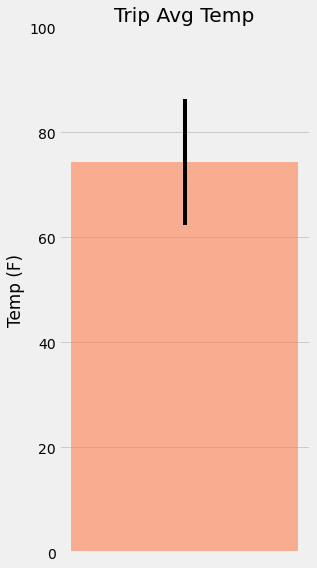

In [95]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
min_temp = my_trip[0][0]
avg_temp = my_trip[0][1]
max_temp = my_trip[0][2]

min_error = avg_temp - min_temp
max_error = max_temp - avg_temp

plt.figure(figsize=(4,9))
plt.bar(0, avg_temp, yerr=[max_temp-min_temp], color = 'coral', alpha=.6)
plt.title('Trip Avg Temp')
plt.ylim(0,100)
plt.ylabel('Temp (F)')
plt.xticks([])
plt.savefig("Images/Temperature_Analysis.png")

plt.show()

In [132]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2017-04-02'
end_date = '2017-04-09'

s = session.query(Station.station,
                  func.sum(Measurement.prcp),
                  Station.name,
                  Station.elevation,                                    
                  Station.latitude,
                  Station.longitude)\
.filter(Measurement.station == Station.station)\
.filter(Measurement.date >= start_date)\
.filter(Measurement.date <= end_date)\
.group_by(Station.station)\
.order_by(func.sum(Measurement.prcp).desc())

for row in s:
    rain="{0:.2f}".format(row[1])
    print (f"Station:  {row[0]}\n    Rainfall:  {rain}  \n    Location:  {row[2]}\n    Elevation:  {row[3]}  \
    Latitude:  {row[4]}  Longitude:  {row[5]}")
    print()

Station:  USC00516128
    Rainfall:  0.70  
    Location:  MANOA LYON ARBO 785.2, HI US
    Elevation:  152.4      Latitude:  21.3331  Longitude:  -157.8025

Station:  USC00519281
    Rainfall:  0.51  
    Location:  WAIHEE 837.5, HI US
    Elevation:  32.9      Latitude:  21.45167  Longitude:  -157.84888999999998

Station:  USC00514830
    Rainfall:  0.16  
    Location:  KUALOA RANCH HEADQUARTERS 886.9, HI US
    Elevation:  7.0      Latitude:  21.5213  Longitude:  -157.8374

Station:  USC00513117
    Rainfall:  0.16  
    Location:  KANEOHE 838.1, HI US
    Elevation:  14.6      Latitude:  21.4234  Longitude:  -157.8015

Station:  USC00519523
    Rainfall:  0.00  
    Location:  WAIMANALO EXPERIMENTAL FARM, HI US
    Elevation:  19.5      Latitude:  21.33556  Longitude:  -157.71139

Station:  USC00519397
    Rainfall:  0.00  
    Location:  WAIKIKI 717.2, HI US
    Elevation:  3.0      Latitude:  21.2716  Longitude:  -157.8168

Station:  USC00517948
    Rainfall:  0.00  
    Locatio

In [138]:
columns = ['station', 'rainfall', 'name', 'elevation' , 'latitude', 'longitude']
rainfall_df = pd.DataFrame(s, columns=columns)
rainfall_df

,station,rainfall,name,elevation,latitude,longitude
0,USC00516128,0.70,"MANOA LYON ARBO 785.2, HI US",152.4,21.33310,-157.80250
1,USC00519281,0.51,"WAIHEE 837.5, HI US",32.9,21.45167,-157.84889
2,USC00514830,0.16,"KUALOA RANCH HEADQUARTERS 886.9, HI US",7.0,21.52130,-157.83740
3,USC00513117,0.16,"KANEOHE 838.1, HI US",14.6,21.42340,-157.80150
4,USC00519523,0.00,"WAIMANALO EXPERIMENTAL FARM, HI US",19.5,21.33556,-157.71139
5,USC00519397,0.00,"WAIKIKI 717.2, HI US",3.0,21.27160,-157.81680
6,USC00517948,0.00,"PEARL CITY, HI US",11.9,21.39340,-157.97510


In [141]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [143]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-04-02'
end_date = '2017-04-09'

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(start = start_date, end = end_date)
# Stip off the year and save a list of %m-%d strings
days = list(np.ravel(pd.to_datetime(trip_dates).strftime("%m-%d")))
days
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
tmin = []
tavg = []
tmax = []

for x in range(len(days)):
    normals.append(daily_normals(days[x]))

tmin = [item[0][0] for item in normals]
tavg = [item[0][1] for item in normals]
tmax = [item[0][2] for item in normals]


In [145]:
trip_dates = list(np.ravel(pd.to_datetime(trip_dates).strftime("%Y-%m-%d")))
trip_dates

['2017-04-02',
 '2017-04-03',
 '2017-04-04',
 '2017-04-05',
 '2017-04-06',
 '2017-04-07',
 '2017-04-08',
 '2017-04-09']

In [146]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
data = {'Date' : trip_dates, 'tmin' : tmin, 'tavg' : tavg, 'tmax' : tmax}
daily_temps = pd.DataFrame(data)
daily_temps.set_index('Date', inplace = True)
daily_temps

,tmin,tavg,tmax
Date,,,
2017-04-02,53.0,71.821429,79.0
2017-04-03,55.0,72.228070,78.0
2017-04-04,58.0,72.016393,78.0
2017-04-05,61.0,72.288136,80.0
2017-04-06,67.0,71.571429,77.0
2017-04-07,63.0,71.105263,78.0
2017-04-08,66.0,72.105263,77.0
2017-04-09,62.0,71.614035,78.0


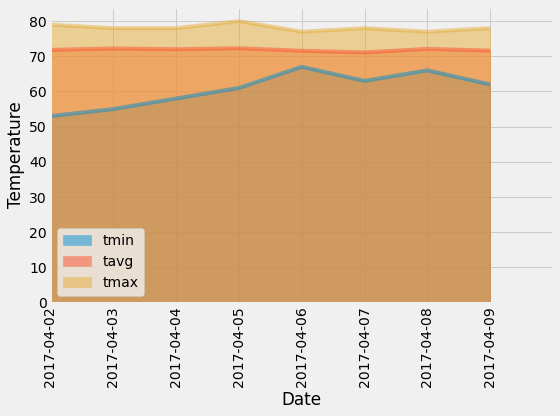

In [149]:
# Plot the daily normals as an area plot with `stacked=False`

ax = daily_temps.plot.area(stacked=False, figsize=(8,6))
plt.ylabel('Temperature')
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend(loc='lower left')
plt.xlim(0,len(days))

plt.savefig("Images/daily normals.png")


plt.show()